# PhaseScorer for Kuramoto order parameters

This script calculates the Kuramoto order parameters r (synchrony) and ψ (mean phase angle) from circadian phase estimates measured over sequential sliding time windows relative to dawn

In [1]:
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt

### Input csv is phase estimates for rhythms measured over sequential windows relative to dawn 0

In [2]:
#df = pd.read_csv('Phases for syncrohnisation_joshs_script.csv')
df = pd.read_csv('phases_marchantia_ara_brassica_wheat.csv')

In [3]:
df.head()

,Marchantia phases LL,Marchantia phases DD,Marchantia phases DD.1,Swedish phases 191 22C,LL_Wheat,LL_brassic a,DD_Wheat,DD_brassic a
0,18.85,15.67,5.64,18.88,4.35,16.50,3.51,16.32
1,11.16,23.39,3.01,20.40,22.07,15.42,4.70,12.72
2,20.73,6.05,6.47,16.70,23.88,16.34,3.40,5.78
3,9.61,6.98,3.00,18.45,4.24,15.13,5.95,3.07
4,8.63,16.83,8.66,18.68,22.25,16.19,4.25,13.15


Select column to get Synchronisation Index for phases across each time window:

In [4]:
column = df.iloc[:, 2]
column.dropna(inplace=True)

In [5]:
column

0      5.64
1      3.01
2      6.47
3      3.00
4      8.66
      ...  
72    10.59
73     7.11
74     8.90
75     8.82
76    13.98
Name: Marchantia phases DD.1, Length: 77, dtype: float64

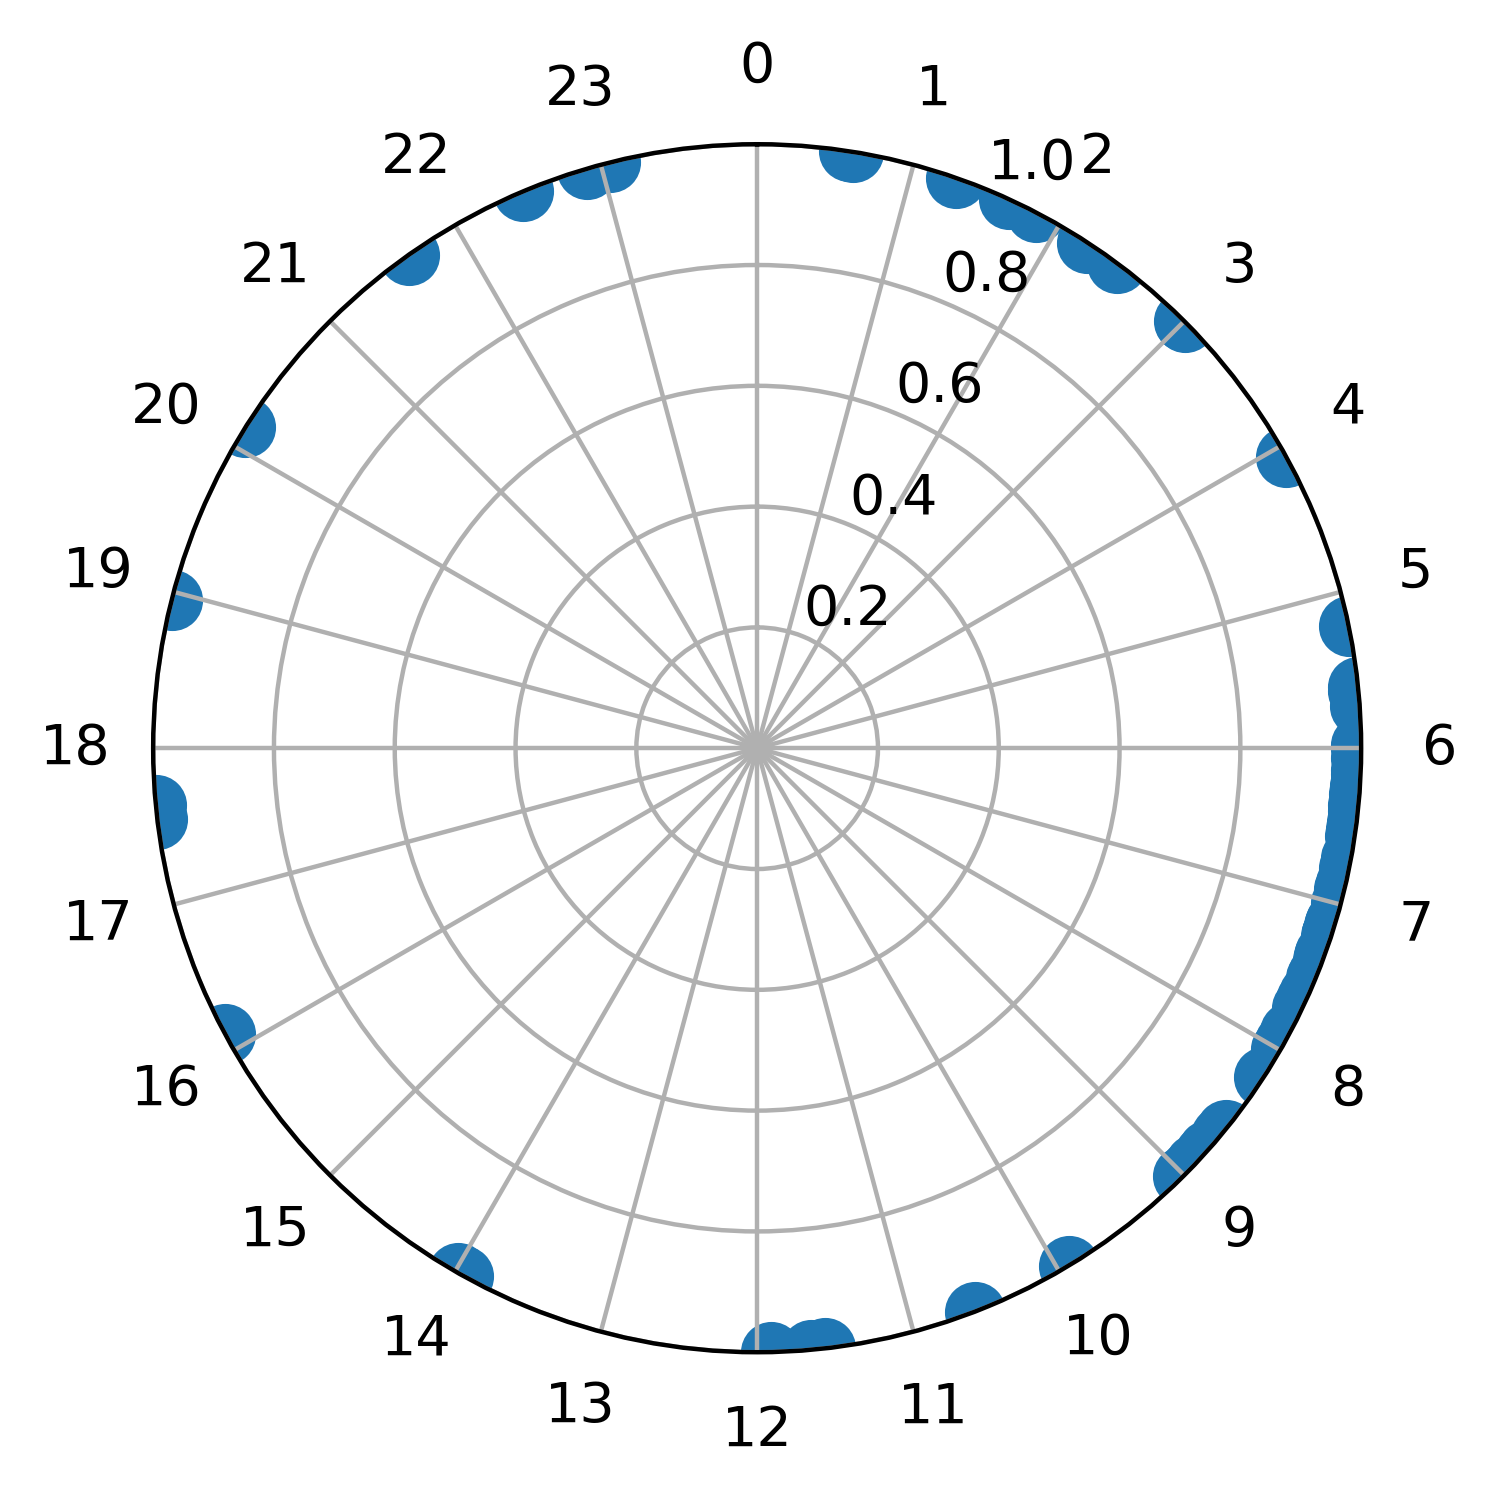

In [6]:
plt.figure(dpi=400)
ax = plt.subplot(111, polar=True)
ax.scatter((column.values * np.pi / 12), np.ones(column.shape[0])*1, s=100)
ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
ax.set_xticklabels(range(24))
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2.0)
plt.ylim(0,1)
plt.show()

Here is some example data to test the function:

In [7]:
def get_kuramoto_params(x):
    """
    Calculates the two Kuramoto parameters: r for measuring synchrony and ψ for the average phase.

    Arguments:
    x = 1D numpy array or pandas series, shape (n) where n is number of timepoints, expects unit of time to be hours

    Returns:
    mag = the magnitude of synchrony (r) between the set of oscillators, between [0-1]
    ang = the average phase (ψ) of the set of oscillators

    If you use this code, consider citing https://www.biorxiv.org/content/10.1101/2022.01.11.475783v1
    """
    if isinstance(x, (pd.Series, pd.DataFrame)):
        x = x.values
    if x.ndim > 1:
        print("Input data must be 1 dimensional")
        return np.nan, np.nan
    # Convert from hours to radians
    x = x * np.pi / 12
    scale_factor = 1/x.shape[0]
    cosine_term, sine_term = 0, 0
    for i in range(x.shape[0]):
        cosine_term += np.cos(x[i])
        sine_term += np.sin(x[i])
    # Get magnitude of combined vector through square root of sum of squares
    mag = scale_factor * np.sqrt(cosine_term**2 + sine_term**2)
    # Calculate angle of combined vector, set to be from positive real axis
    ang = math.atan2(cosine_term, sine_term)
    ang += 2*np.pi
    ang = ang % (2*np.pi)
    return mag, ang

In [8]:
example_data = pd.Series(np.array([3, 4, 6, 19]))
magnitude, angle = get_kuramoto_params(example_data)
magnitude, angle

(0.5438319367902686, 0.739457696861404)

Magnitude: 0.6116962126963361 Phase (hours):  6.704690894528627


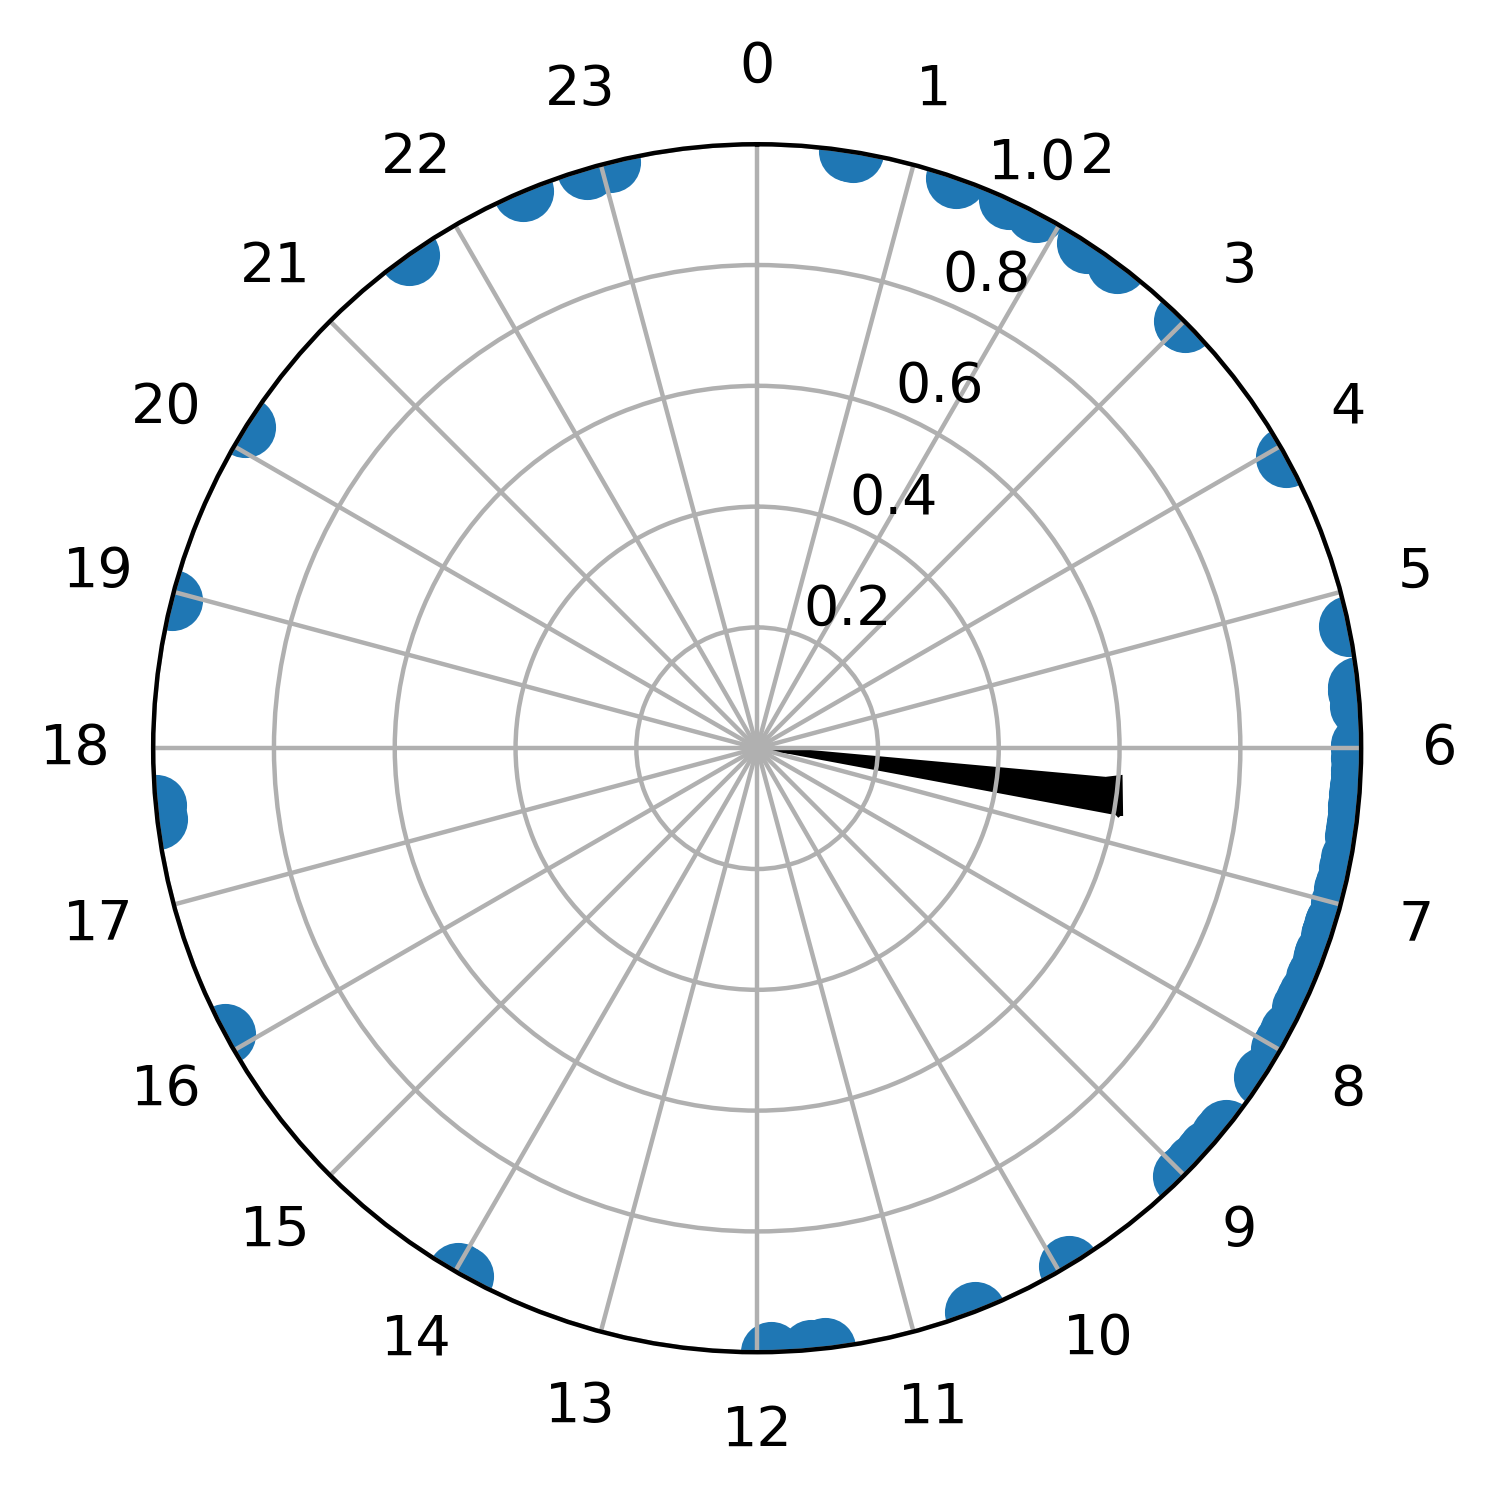

In [9]:
plt.figure(dpi=400)
ax = plt.subplot(111, polar=True)
ax.scatter((column.values * np.pi / 12), np.ones(column.shape[0])*1, s=100)
ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
ax.set_xticklabels(range(24))
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2.0)
plt.ylim(0,1)
magnitude, angle = get_kuramoto_params(column)
angle = ((2*np.pi) - angle + np.pi/2) % (2*np.pi)
print("Magnitude:", magnitude, "Phase (hours): ", angle/np.pi * 12)
plt.arrow(0, 0, angle, magnitude, head_width=0.05, head_length=0.1, fc='k', ec='k', length_includes_head=True)
plt.show()

In [10]:
def check_negative(s):
    try:
        f = float(s)
        if (f < 0):
            return 24+f
        # Otherwise return false
        return f
    except ValueError:
        return False

In [11]:
magnitude_list = []
angle_list = []
items = list(df)
for (columnName, columnData) in df.iteritems():
    columnData.dropna(inplace=True)
    magnitude, angle = get_kuramoto_params(columnData)
    print(magnitude, angle)
    magnitude_list.append(magnitude)
    clock_angle=6-(angle*12/math.pi)
    clock_angle=check_negative(clock_angle)
    angle_list.append(clock_angle)    

0.059389997996199144 6.18368772517953
0.2741307981637875 4.551337608926002
0.6116962126963361 6.098697662404357
0.9203676048244004 3.076753233818458
0.32656271234615414 1.3972966096174755
0.9618434347990243 3.9691972103982733
0.9371327460130311 0.32027668711334556
0.4716544869760845 6.029038029054449


In [12]:
df2 = pd.DataFrame(list(zip(items, magnitude_list,angle_list)),
               columns =['Phase window/condition', 'Kuramoto r synchrony','Kuramoto ψ mean phase angle'])

In [13]:
df2

,Phase window/condition,Kuramoto r synchrony,Kuramoto ψ mean phase angle
0,Marchantia phases LL,0.059390,6.380053
1,Marchantia phases DD,0.274131,12.615171
2,Marchantia phases DD.1,0.611696,6.704691
3,Swedish phases 191 22C,0.920368,18.247668
4,LL_Wheat,0.326563,0.662720
5,LL_brassic a,0.961843,14.838783
6,DD_Wheat,0.937133,4.776633
7,DD_brassic a,0.471654,6.970771
